## Liberías a utilizar

In [2]:
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd

## Funciones Modelo y Verosimilitud

In [3]:
"""
Funciones para el modelo SIR
"""
# MODELO
def modelo(y, t, beta, gamma, eta, mu, theta, N):
    S, E, I, R = y
    dSdt = mu * N - (beta * S * I / N) - mu * S + theta * R
    dEdt = (beta * S * I / N) - (mu + gamma) * E
    dIdt = gamma * E - (mu + eta) * I
    dRdt = eta * I - (mu + theta) * R
    return [dSdt, dEdt, dIdt, dRdt]

# Modelo en el tiempo ****PRUEBA****
def sim_mod_time(beta, gamma, eta, mu, theta, S0, E0, I0, R0, N, time):
    # Cond Iniciales
    y0 = [S0, E0, I0, R0]
    # Resolvemos el sistema
    ret = odeint(modelo, y0, time, args=(beta, gamma, eta, mu, theta, N))
    # Obtenemos los valores de I para luego compararlos con los datos reales
    S, E, I, R = ret.T
    return I

"""
Funciones estadísticas
"""

# Verosimilitud que nos ayude a comparar los datos reales con los simulados
def likelihood(data, predicted_cases):
    # Asumimos normalidad de errores xd
    sigma = np.std(data) 
    return -0.5 * np.sum((data - predicted_cases)**2 / sigma**2)


## MCMC

Utilizaremos Metroplosi Hasting, un método MCMC que propone nuevos valores de estimadores y decide si los acepta o rechaza.

In [4]:
"""
MCMC
"""

# !!******PRUEBA 1 DE MCMC******!!
def mcmc(data, param_0, iter, time):
    # Parametros iniciales la neta completamente aleatorios jajsjdlkajdfkjasdf
    beta, gamma, eta, mu, theta = param_0
    # Parametros aceptados
    accepted_params = []
    # Verosimilitud actual
    current_likelihood = likelihood(data, sim_mod_time(beta, gamma, eta, mu, theta, S0, E0, I0, R0, N, time))
    
    for i in range(iter):
        # Se proponen nuevos parametros, con una distribucion uniforme, moviendolos poquito namas
        new_params = [
            beta + random.uniform(-0.01, 0.01),
            gamma + random.uniform(-0.01, 0.01),
            eta + random.uniform(-0.01, 0.01),
            mu + random.uniform(-0.001, 0.001),
            theta + random.uniform(-0.01, 0.01)
        ]
        
         
        new_predicted = sim_mod_time(*new_params, S0, E0, I0, R0, N, time)
        
        # Calculate new likelihood
        new_likelihood = likelihood(data, new_predicted)
        
        # Acceptance probability
        accept_prob = np.exp(new_likelihood - current_likelihood)
        
        if accept_prob > random.uniform(0, 1):
            # Accept new parameters
            beta, gamma, eta, mu, theta = new_params
            current_likelihood = new_likelihood
            accepted_params.append(new_params)
    
    return accepted_params

In [5]:
cleaned_data = pd.read_csv('cleaned_epidemiology_data.csv')

param_0 = [0.2, 0.1, 0.05, 0.001, 0.01]

time = np.linspace(0, len(cleaned_data), len(cleaned_data)) 

S0 = 999900
E0 = 100
I0 = cleaned_data['new_confirmed'].iloc[0]
R0 = 0
N = S0 + E0 + I0 + R0 


iter = 5000
mcmc_results = mcmc(cleaned_data['new_confirmed'].values, param_0, iter , time)


mcmc_results[:5]


C:\Users\lebue\AppData\Local\Temp\ipykernel_26100\3102774617.py:31: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(new_likelihood - current_likelihood)
c:\Users\lebue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[[0.20468002265142132,
  0.09739297676826479,
  0.059357119724246954,
  0.0004425191270070938,
  0.013595761763113095],
 [0.2031282062774061,
  0.09641492661681954,
  0.05362639643580361,
  0.001159852474789231,
  0.0056783083928073665],
 [0.20577691187592922,
  0.08788615302575452,
  0.05672108694615427,
  0.0008556263810568827,
  0.003700246893860804],
 [0.19915750201864196,
  0.08856051980588135,
  0.054475652371643014,
  9.434531180771357e-05,
  -0.005028030306589963],
 [0.19920175863380865,
  0.09793892745361729,
  0.05877483280907135,
  0.0010520278862146632,
  -0.0019355936769687807]]

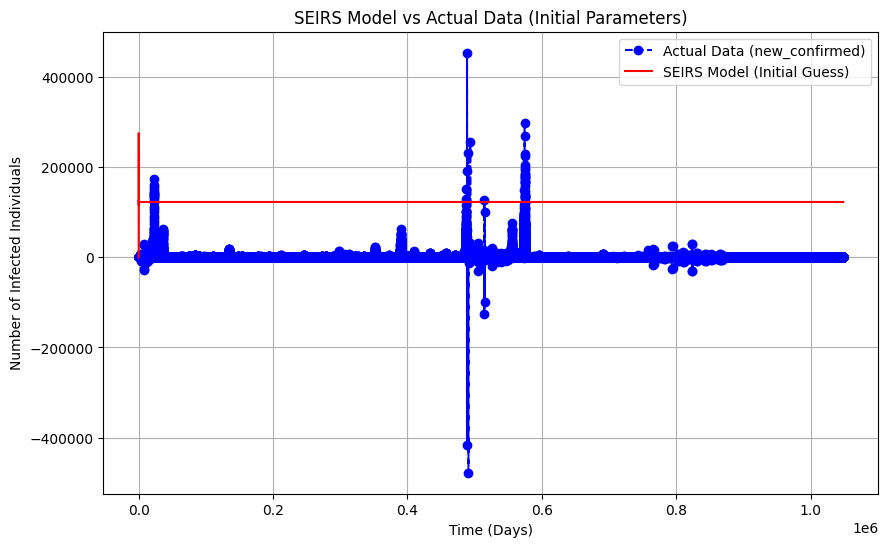

In [6]:
import matplotlib.pyplot as plt

# Generate the initial prediction using the SEIRS model
initial_predicted = sim_mod_time(*param_0, S0, E0, I0, R0, N, time)

# Plot the actual data vs the model's initial prediction
plt.figure(figsize=(10, 6))
plt.plot(time, cleaned_data['new_confirmed'], label='Actual Data (new_confirmed)', color='blue', marker='o', linestyle='--')
plt.plot(time, initial_predicted, label='SEIRS Model (Initial Guess)', color='red', linestyle='-')

plt.title('SEIRS Model vs Actual Data (Initial Parameters)')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Infected Individuals')
plt.legend()
plt.grid(True)
plt.show()